# 線形最適化問題入門

# 2.1.3 Pythonで解いてみる

## コード2.1（p. 28）

In [1]:
from pulp import *
prob = LpProblem(name='LP-Sample', sense=LpMaximize)
x1 = LpVariable('x1', lowBound=0.0)
x2 = LpVariable('x2', lowBound=0.0)
prob += 2*x1 + 3*x2 # 目的関数の設定
prob += x1 + 3*x2 <= 9, 'ineq1'
prob += x1 + x2 <= 4, 'ineq2'
prob += x1 + x2 <= 10, 'ineq3'
print(prob) # 問題を出力
prob.solve() # 求解
#結果を表示
print(LpStatus[prob.status])
print('Optimal value =', value(prob.objective))
for  v in prob.variables():
    print(v.name,'=',value(v))

LP-Sample:
MAXIMIZE
2*x1 + 3*x2 + 0
SUBJECT TO
ineq1: x1 + 3 x2 <= 9

ineq2: x1 + x2 <= 4

ineq3: x1 + x2 <= 10

VARIABLES
x1 Continuous
x2 Continuous

Optimal
Optimal value = 10.5
x1 = 1.5
x2 = 2.5


## コード2.2（pp. 29-30）

In [2]:
from pulp import *
import numpy as np
A = np.array([[3,1,2],[1,3,0],[0,2,4]])
c = np.array([150,200,300])
b = np.array([60,36,48])
(m,n) = A.shape # mはAの行数，nはAの列数
prob = LpProblem(name='Production', sense=LpMaximize)
x = [LpVariable('x'+str(i+1), lowBound=0) for i in range(n)]
prob += lpDot(c,x)
for i in range(m):
    prob += lpDot(A[i],x) <= b[i], 'ineq'+str(i)
print(prob)
prob.solve()
print(LpStatus[prob.status])
print('Optimal value =', value(prob.objective))
for  v in prob.variables():
    print(v.name,'=',v.varValue)

Production:
MAXIMIZE
150*x1 + 200*x2 + 300*x3 + 0
SUBJECT TO
ineq0: 3 x1 + x2 + 2 x3 <= 60

ineq1: x1 + 3 x2 <= 36

ineq2: 2 x2 + 4 x3 <= 48

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous

Optimal
Optimal value = 5800.0
x1 = 12.0
x2 = 8.0
x3 = 8.0


# 2.2.1 双対問題の導入

## 実行可能性の確認（p. 31）

In [3]:
X = np.array([v.varValue for v in prob.variables()])
np.all(np.abs(b - np.dot(A,X)) <= 1.0e-5)

True

# 2.2.2 双対定理

## コード2.3（p. 35）

In [4]:
# 生産計画の双対問題，Aの転地行列をATに代入
AT = A.T
dual= LpProblem(name='Dual_Production', sense=LpMinimize)
y = [LpVariable('y'+str(i+1), lowBound=0) for i in range(m)]
dual += lpDot(b,y)
for j in range(n):
    dual += lpDot(AT[j],y) >= c[j], 'ineq'+str(j)
# 求解して結果を表示
dual.solve()
print(LpStatus[dual.status])
print('Optimal value of dual problem =', value(dual.objective))
for  v in dual.variables():
    print(v.name,'=',v.varValue)

Optimal
Optimal value of dual problem = 5799.999996
y1 = 44.444444
y2 = 16.666667
y3 = 52.777778


In [5]:
Y = np.array([v.varValue for v in dual.variables()])
np.all(np.abs(np.dot(AT,Y) - c) <= 1.0e-5)

True

# 2.3.2 シンプレックス法の実装

## コード2.4，改訂シンプレックス法（p. 45）

In [6]:
import numpy as np
import scipy.linalg as linalg
MEPS = 1.0e-10

def lp_RevisedSimplex(c,A,b):
    np.seterr(divide='ignore')
    (m,n) = A.shape # mはAの行数，nはAの列数
    AI = np.hstack((A,np.identity(m)))
    c0 = np.r_[c,np.zeros(m)]
    basis = [n+i for i in range(m)]
    nonbasis = [j for j in range(n)]
    
    while True:
        y = linalg.solve(AI[:,basis].T, c0[basis])
        cc = c0[nonbasis]-np.dot(y,AI[:,nonbasis])
        
        if np.all(cc <= MEPS): # 最適性判定
            x = np.zeros(n+m)
            x[basis] = linalg.solve(AI[:,basis], b)
            print('Optimal')
            print('Optimal value =',np.dot(c0[basis],x[basis]))
            for i in range(m):
                print('x',i, '=', x[i])
            break
        else:
            s = np.argmax(cc)
        d = linalg.solve(AI[:,basis], AI[:,nonbasis[s]])
        if np.all(d <= MEPS): # 非有界性判定
            print('Unbounded')
            break
        else:
            bb = linalg.solve(AI[:,basis], b)
            ratio = bb/d
            ratio[ratio<-MEPS] = np.inf
            r = np.argmin(ratio)
            # 基底と非基底の入れ替え
            nonbasis[s], basis[r] = basis[r], nonbasis[s] 

In [7]:
import numpy as np
# 問題を決定する，係数行列，コストベクトル，右側ベクトルを定義
A = np.array([[2,2,-1],[2,-2,3],[0,2,-1]])
c = np.array([4,3,5])
b = np.array([6,8,4])

lp_RevisedSimplex(c,A,b)

Optimal
Optimal value = 45.0
x 0 = 0.0
x 1 = 4.999999999999999
x 2 = 6.0


# 2.3.4 内点法の実装

## コード2.5（p. 57）

In [8]:
import numpy as np

def make_Mq_from_cAb(c,A,b):
    m, k = A.shape
    m1 = np.hstack((np.zeros((m,m)), -A, b.reshape(m,-1)))
    m2 = np.hstack((A.T, np.zeros((k,k)), -c.reshape(k,-1)))
    m3 = np.append(np.append(-b,c),0)
    M = np.vstack((m1,m2,m3))
    q = np.zeros(m+k+1)
    return M, q

## コード2.6（p. 58）

In [9]:
def make_artProb_initialPoint(M,q):
    n, n = M.shape

    x0 = np.ones(n)
    mu0 = np.dot(q,x0)/(n+1)+1
    z0 = mu0/x0
    r = z0 - np.dot(M,x0) - q
    qn1= (n+1)*mu0

    MM = np.hstack((M, r.reshape((-1,1))))
    print(MM)
    MM = np.vstack((MM, np.append(-r,0)))
    qq = np.append(q, qn1)
    xx0 = np.append(x0, 1)
    zz0 = np.append(z0, mu0)
    return MM, qq, xx0, zz0

## コード2.7（pp. 58-59）

In [10]:
MEPS = 1.0e-10

def PrimalDualPathFollowing(c, A, b):
    (M0, q0) = make_Mq_from_cAb(c,A,b)
    (M, q, x, z) = make_artProb_initialPoint(M0,q0)
    m, k = A.shape
    n, n = M.shape

    count = 0
    mu = np.dot(z,x)/n
    print('初期目的関数値:', mu)
    while mu > MEPS:
        count += 1
        print(count, '回目: ', end=' ')
        # 予測ステップ
        delta = 0
        dx = np.dot(np.linalg.inv(M+np.diag(z/x)), 
                    delta*mu*(1/x)- z )
        dz = delta*mu*(1/x)-z-np.dot(np.diag(1/x), z*dx)
        th = binarysearch_theta(x,z,dx,dz,0.5,0.001)
        print('theta =', th, end=', ')
        x = x + th*dx
        z = z + th*dz
        mu = np.dot(z,x)/n
        # 修正ステップ
        delta = 1
        dx = np.dot(np.linalg.inv(M+np.diag(z/x)),
                    delta*mu*(1/x)- z )
        dz = delta*mu*(1/x)-z-np.dot(np.diag(1/x), z*dx)
        x = x + dx
        z = z + dz
        mu = np.dot(z,x)/n
        print('目的関数値:', mu)
    
    if x[n-2] > MEPS:
        print('Optimal solution:', x[m:m+k]/x[n-2],
              ' has been found.')
        print('Optimal value = ', np.dot(c,x[m:m+k]/x[n-2]))
        print('Optimal solution(dual) ',  x[:m]/x[n-2],
              ' has been found.')
        print('Optimal value = ', np.dot(b,x[:m]/x[n-2]))


## コード2.8（p. 60）

In [11]:
import numpy as np

def binarysearch_theta(x,z,dx,dz,beta=0.5,precision=0.001):
    n = np.alen(x)
    
    th_low = 0.0
    th_high = 1.0
    if np.alen(-x[dx<0]/dx[dx<0]) > 0:
        th_high = min(th_high, np.min(-x[dx<0]/dx[dx<0]))
    if np.alen(-z[dz<0]/dz[dz<0]) > 0:
        th_high = min(th_high, np.min(-z[dz<0]/dz[dz<0]))

    x_low = x + th_low*dx
    z_low = z + th_low*dz
    x_high = x + th_high*dx
    z_high = z + th_high*dz
    mu_high = np.dot(x_high, z_high)/n
    if (beta*mu_high >=
        np.linalg.norm(x_high*z_high - mu_high*np.ones(n))):
        return th_high
    while th_high - th_low > precision:
        th_mid = (th_high + th_low)/2
        x_mid = x + th_mid*dx
        z_mid = z + th_mid*dz
        mu_mid = np.dot(x_mid, z_mid)/n
        if (beta*mu_mid >=
            np.linalg.norm(x_mid*z_mid - mu_mid*np.ones(n))):
            th_low = th_mid
        else:
            th_high = th_mid
    return th_low

## 内点法での求解の例（p. 61）

In [12]:
c = np.array([150,200,300])
A = np.array([[3,1,2],[1,3,0], [0,2,4]])
b = np.array([60, 36, 48])

PrimalDualPathFollowing(c, A, b)

[[   0.    0.    0.   -3.   -1.   -2.   60.  -53.]
 [   0.    0.    0.   -1.   -3.    0.   36.  -31.]
 [   0.    0.    0.    0.   -2.   -4.   48.  -41.]
 [   3.    1.    0.    0.    0.    0. -150.  147.]
 [   1.    3.    2.    0.    0.    0. -200.  195.]
 [   2.    0.    4.    0.    0.    0. -300.  295.]
 [ -60.  -36.  -48.  150.  200.  300.    0. -505.]]
初期目的関数値: 1.0
1 回目:  theta = 0.5660404758396571, 目的関数値: 0.4339595241603431
2 回目:  theta = 0.5559306039282481, 目的関数値: 0.1927081438134679
3 回目:  theta = 0.6220741646734089, 目的関数値: 0.07282938622494173
4 回目:  theta = 0.6928572905845958, 目的関数値: 0.022369015010189498
5 回目:  theta = 0.7495245360789241, 目的関数値: 0.005602889412134724
6 回目:  theta = 0.8709944026484285, 目的関数値: 0.0007228040955072353
7 回目:  theta = 0.9758700546523815, 目的関数値: 1.744122332162441e-05
8 回目:  theta = 0.9989571758106379, 目的関数値: 1.818812957185667e-08
9 回目:  theta = 0.999023291484274, 目的関数値: 1.7764501037960393e-11
Optimal solution: [12.  8.  8.]  has been found.
Optimal value 

# 2.4.1クラス編成問題

## コード2.9（p. 63）

In [13]:
import pandas as pd # データ分析

df = pd.read_excel('data.xlsx')
df

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16
S001,NaN,1.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.0
S002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,2.0,NaN,4.0,NaN
S003,4.0,NaN,NaN,NaN,1.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S004,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,3.0,NaN
S005,2.0,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
S006,NaN,2.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
S007,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
S008,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
S009,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN
S010,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0


## コード2.10（p. 64）

In [14]:
for i in df.index:
    if (df.loc[i] == 1).sum() == 1 and \
        (df.loc[i] == 2).sum() == 1 and \
        (df.loc[i] == 3).sum() == 1 and \
        (df.loc[i] == 4).sum() == 1:
        print(i, 'ok')
    else:
        print(i, 'NG')

S001 ok
S002 ok
S003 ok
S004 ok
S005 ok
S006 ok
S007 ok
S008 ok
S009 ok
S010 ok
S011 ok
S012 ok
S013 ok
S014 ok
S015 ok
S016 ok
S017 ok
S018 ok
S019 ok
S020 ok
S021 ok
S022 ok
S023 ok
S024 ok
S025 ok
S026 ok
S027 ok
S028 ok
S029 ok
S030 ok
S031 ok
S032 ok
S033 ok
S034 ok
S035 ok
S036 ok
S037 ok
S038 ok
S039 ok
S040 ok
S041 ok
S042 ok
S043 ok
S044 ok
S045 ok
S046 ok
S047 ok
S048 ok
S049 ok
S050 ok
S051 ok
S052 ok
S053 ok
S054 ok
S055 ok
S056 ok
S057 ok
S058 ok
S059 ok
S060 ok
S061 ok
S062 ok
S063 ok
S064 ok
S065 ok
S066 ok
S067 ok
S068 ok
S069 ok
S070 ok
S071 ok
S072 ok
S073 ok
S074 ok
S075 ok
S076 ok
S077 ok
S078 ok
S079 ok
S080 ok
S081 ok
S082 ok
S083 ok
S084 ok
S085 ok
S086 ok
S087 ok
S088 ok
S089 ok
S090 ok


## コード2.11（p. 64）

In [15]:
d = {j: [(df.loc[:,j]==1).sum(), (df.loc[:,j]==2).sum(),
         (df.loc[:,j]==3).sum(), (df.loc[:,j]==4).sum(),
        (df.loc[:,j]>0).sum()] for j in df.columns}
df2 = pd.DataFrame(d,
        index=['第1希望','第2希望','第3希望','第4希望','合計'])
df2

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16
第1希望,1,9,1,1,14,17,0,5,5,9,5,14,1,4,0,4
第2希望,7,10,1,4,3,10,3,10,4,10,5,14,1,3,0,5
第3希望,3,8,4,5,7,10,2,11,1,6,6,13,0,1,4,9
第4希望,13,5,0,6,1,8,4,11,1,2,1,9,5,6,7,11
合計,24,32,6,16,25,45,9,37,11,27,17,50,7,14,11,29


## コード2.12（p. 65）

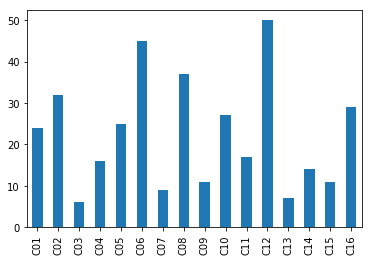

In [16]:
%matplotlib inline
df2.loc['合計'].plot(kind='bar');

## コード2.13（p. 65）

In [17]:
from pulp import * # 最適化ソルバー
from itertools import product # 繰り返しのため
import math # floor, ceil 関数のため
MEPS = 1.0e-6 
n = len(df.index) # 学生の人数
m = len(df.columns) # クラスの数
lb = math.floor(n/m) # 1クラス人数の下限
ub = math.ceil(n/m) # 1クラス人数の上限
# 満足度 希望順位:点数 のフォーマット
score = {1:100, 2:50, 3:20, 4:0}
ngscore = -100000 # 希望外
prob = LpProblem('ClassAssignment', sense=LpMaximize)
# 変数 x と満足度関数 p を同時に設定
x = {}
p = {}
for i,j in product(df.index, df.columns):
    x[i,j] = LpVariable('x('+str(i)+','+str(j)+')', lowBound=0)
    p[i,j] = score[int(df.loc[i,j])] \
        if df.loc[i,j]>MEPS else ngscore
# 目的関数
prob += lpSum(p[i,j]*x[i,j] \
              for i,j in product(df.index, df.columns))
# 制約式
for i in df.index:
    prob += lpSum(x[i,j] for j in df.columns) == 1
for j in df.columns:
    prob += lpSum(x[i,j] for i in df.index) >= lb
    prob += lpSum(x[i,j] for i in df.index) <= ub
# 最適化
prob.solve()
# 解の出力
print(LpStatus[prob.status])
print('学生の満足度の総計は',  int(value(prob.objective)))
print('学生一人あたりの平均満足度は',  int(value(prob.objective))/90.0)

Optimal
学生の満足度の総計は 6220
学生一人あたりの平均満足度は 69.11111111111111


## コード2.14（p. 67）

In [18]:
dfr = df.copy()
for i,j in product(dfr.index,dfr.columns):
    dfr.loc[i,j] = df.loc[i,j] if x[i,j].varValue > MEPS else 0

d2 = {j: [(dfr.loc[:,j]==1).sum(), (dfr.loc[:,j]==2).sum(),
        (dfr.loc[:,j]==3).sum(), (dfr.loc[:,j]==4).sum(),
        (dfr.loc[:,j]>0).sum(),
          sum([p[i,j] for i in df.index
               if x[i,j].varValue > MEPS])] for j in dfr.columns}
df3 = pd.DataFrame(d2,
        index=['第1希望','第2希望','第3希望',
               '第4希望','合計', 'クラス満足度'])
df3

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16
第1希望,1,6,1,1,6,6,0,2,4,6,2,6,1,4,0,4
第2希望,3,0,0,2,0,0,3,4,1,0,3,0,1,1,0,2
第3希望,1,0,4,1,0,0,2,0,0,0,1,0,0,1,1,0
第4希望,0,0,0,2,0,0,0,0,0,0,0,0,3,0,4,0
合計,5,6,5,6,6,6,5,6,5,6,6,6,5,6,5,6
クラス満足度,270,600,180,220,600,600,190,400,450,600,370,600,150,470,20,500


# 2.4.2 DEA

## コード2.15（pp. 70-71）

In [19]:
import numpy as np
from pulp import *
MEPS = 1.0e-6

def DEA_CCR(x, y, DMUs):
    m, n = x.shape
    s, n = y.shape

    res = []
    for o in range(n):
        prob = LpProblem('DMU_'+str(o), LpMaximize)
        v = [LpVariable('v'+str(i), lowBound=0,
                        cat='Continuous') for i in range(m)]
        u = [LpVariable('u'+str(i), lowBound=0,
                        cat='Continuous') for i in range(s)]
        
        prob += lpDot(u, y[:,o]) # 目的関数
        
        #　制約条件
        prob += lpDot(v, x[:,o])==1, 'Normalize'+str(o) 
        for j in range(n):
            prob += lpDot(u, y[:,j]) <= lpDot(v, x[:, j])

        prob.solve()
        vs = np.array([v[i].varValue for i in range(m)]) # v*
        us = np.array([u[i].varValue for i in range(s)])  # u*
        # 参照集合作成
        (eo,) = np.where(np.abs(np.dot(vs,x)-np.dot(us,y))<=MEPS) 
        res.append([DMUs[o], value(prob.objective),
                    set(eo), tuple(vs), tuple(us)])
    return res

In [20]:
x = np.array([[321.774, 1376.049, 64.716, 143.457,
    80.689, 64.395, 126.573, 23.969, 59.798, 35.94],
  [14682.739, 5320.232, 2676.52, 999.832, 3226.726,
    2361.317, 4780.944, 975.012, 1745.045, 1359.773]])
y = np.array([[46, 26, 27, 19, 17, 10, 12, 8, 8, 4],
 [37, 18, 23, 18, 10, 18, 8, 11, 12, 3],
 [38, 26, 17, 19, 15, 14, 21, 10, 8, 15]])

DMUs = ['アメリカ', '中国', 'イギリス', 'ロシア', 'ドイツ', 'フランス',
    '日本', 'オーストラリア', 'イタリア', 'カナダ']

res = np.array(DEA_CCR(x,y, DMUs))
results = [[x[0],x[1], list(res[:,0][list(x[2])])] for x in res]
results = sorted(results, key=lambda x: x[1], reverse=True)

In [21]:
results

[['オーストラリア', 1.000000002, ['カナダ', 'ロシア', 'オーストラリア']],
 ['ロシア', 1.0000000009999999, ['ロシア']],
 ['カナダ', 0.9999999978, ['カナダ', 'ロシア', 'オーストラリア']],
 ['イギリス', 0.9999999970000001, ['イギリス', 'オーストラリア']],
 ['フランス', 0.666693702, ['ロシア', 'オーストラリア']],
 ['イタリア', 0.581318664, ['ロシア', 'オーストラリア']],
 ['ドイツ', 0.567588247, ['イギリス', 'ロシア', 'オーストラリア']],
 ['日本', 0.4118923692, ['カナダ', 'ロシア', 'オーストラリア']],
 ['アメリカ', 0.3697814572, ['イギリス', 'オーストラリア']],
 ['中国', 0.257167573, ['ロシア']]]

# 2.4.3 多面体描画

## コード2.16（pp. 72-73）

In [22]:
import numpy as np
import cdd
from itertools import combinations
MEPS = 1.0e-6
# 多面体を定義する不等式の作成
np.random.seed(2)
n, d = 40, 3
A = np.random.randint(0,100,(n,d))
b = np.sqrt(np.dot(A**2,np.ones(d))).astype(np.int64)
m, n = np.shape(A)
# pycddlib用のフォーマットに合わせる．
eb = np.hstack((b, np.zeros(n))).reshape(-1,1)
eA = np.vstack((-A,np.identity(n)))
ar = np.hstack((eb,eA))
mat = cdd.Matrix(ar,number_type='fraction')
# 端点列挙実行
poly = cdd.Polyhedron(mat)
ext = poly.get_generators()
vl = np.array([np.array(v[1:])/v[0] for v in ext if v[0] != 0])
vlist = vl.astype(np.float64)
# 付加情報の計算
zerosets = [set([i for i in range(m+n)
                 if abs(eb[i]+np.dot(eA[i],v)) <= MEPS]) for v in vl]
elist = [[i,j] for i,j in combinations(range(len(vl)),2)
       if len(zerosets[i].intersection(zerosets[j])) >= 2]

## コード2.17（p. 73）

In [23]:
from vpython import *
# vpython 初期設定
scene = canvas(width = 800,height = 600)
vmin = np.min(vlist)-0.5
length = np.max(vlist)-vmin+0.5
scene.up = vector(0,0,1)
scene.forward = vector(-1,-1,-1)
scene.center = vector(0,0,0)
scene.range = 0.9*length
scene.background = color.white
cb = color.black
# x,y,z軸を描画
arrow(pos=vector(vmin,0,0),axis=vector(length,0,0),
      shaftwidth=0.002,headwidth=0.05,color=cb)
arrow(pos=vector(0,vmin,0),axis=vector(0,length,0),
      shaftwidth=0.002,headwidth=0.05,color=cb)
arrow(pos=vector(0,0,vmin),axis=vector(0,0,length),
      shaftwidth=0.002,headwidth=0.05,color=cb)
# 頂点と稜線を描画
vertices = [sphere(pos=vector(*v),
                radius=0.01,color=cb) for v in vlist]
edges = [curve(pos=[vector(*vlist[i]), vector(*vlist[j])],
               radius=0.007,color=cb) for [i,j] in elist]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>